<a href="https://colab.research.google.com/github/gpasxos/large-scale-optimization/blob/main/ch05_Projected_Gradient_Descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Solve the problem
$$\text{minimize}_{x\geq 0} ~~ \frac{1}2 x^TQx + c^Tx \\
\text{subject to}~~~ \sum_{i=1}^n x_n =1$$
using Projected Gradient Descent.

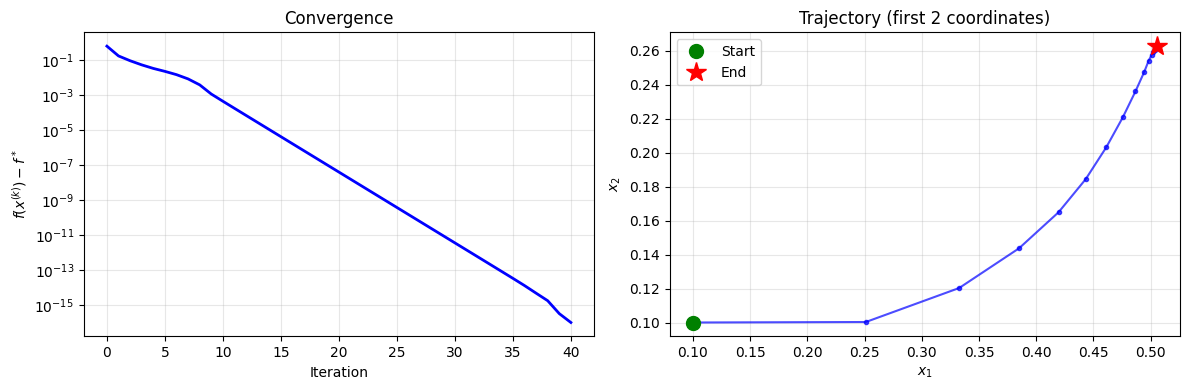

Optimal x (should sum to 1): [0.5052976  0.26276442 0.         0.21069877 0.         0.02123921
 0.         0.         0.         0.        ]
Sum: 1.000000, Min: 0.000000


In [2]:
import numpy as np
import matplotlib.pyplot as plt

def project_simplex(y):
    """Project onto probability simplex {x >= 0, sum(x) = 1}."""
    n = len(y)
    # Sort in descending order
    y_sorted = np.sort(y)[::-1]

    # Find rho
    cumsum = np.cumsum(y_sorted)
    rho = np.where(y_sorted - (cumsum - 1) / np.arange(1, n+1) > 0)[0][-1] + 1

    # Compute threshold
    tau = (cumsum[rho-1] - 1) / rho

    return np.maximum(y - tau, 0)

def projected_gradient_descent(f, grad_f, project, x0, eta, max_iter=1000, tol=1e-8):
    """
    Projected gradient descent.
    Parameters:
    f: objective function
    grad_f: gradient function
    project: projection function onto constraint set
    x0: initial point (should be feasible)
    eta: step size (or function of iteration)
    max_iter: maximum iterations
    tol: tolerance for stopping
    """
    x = project(x0) # Ensure feasibility
    history = {'f': [f(x)], 'x': [x.copy()]}

    for k in range(max_iter):
        grad = grad_f(x)

        # Step size (constant or callable)
        step = eta if not callable(eta) else eta(k)

        # Gradient step then projection
        y = x - step * grad
        x_new = project(y)

        history['f'].append(f(x_new))
        history['x'].append(x_new.copy())

        # Check convergence
        if np.linalg.norm(x_new - x) < tol:
            break

        x = x_new

    return x, history

# Example: minimize quadratic over simplex
def demo_projected_gd():
    np.random.seed(42)
    n = 10

    # f(x) = 0.5 * x'Qx + c'x
    Q = np.eye(n) + 0.5 * np.random.randn(n, n)
    Q = Q @ Q.T # Make positive definite
    c = np.random.randn(n)

    f = lambda x: 0.5 * x @ Q @ x + c @ x
    grad_f = lambda x: Q @ x + c

    # Constraint: probability simplex
    project = project_simplex

    # Initial point
    x0 = np.ones(n) / n # Uniform distribution

    # Run projected GD
    M = np.max(np.linalg.eigvalsh(Q))
    eta = 1.0 / M

    x_opt, history = projected_gradient_descent(f, grad_f, project, x0, eta, max_iter=500)

    # Plot convergence
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    f_star = min(history['f'])
    axes[0].semilogy([fval - f_star + 1e-16 for fval in history['f']], 'b-', linewidth=2)
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('$f(x^{(k)}) - f^*$')
    axes[0].set_title('Convergence')
    axes[0].grid(True, alpha=0.3)

    # Plot trajectory of first two coordinates
    trajectory = np.array(history['x'])
    axes[1].plot(trajectory[:, 0], trajectory[:, 1], 'b.-', alpha=0.7)
    axes[1].plot(trajectory[0, 0], trajectory[0, 1], 'go', markersize=10, label='Start')
    axes[1].plot(trajectory[-1, 0], trajectory[-1, 1], 'r*', markersize=15, label='End')
    axes[1].set_xlabel('$x_1$')
    axes[1].set_ylabel('$x_2$')
    axes[1].set_title('Trajectory (first 2 coordinates)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('projected_gd.pdf', bbox_inches='tight')
    plt.show()

    print(f"Optimal x (should sum to 1): {x_opt}")
    print(f"Sum: {x_opt.sum():.6f}, Min: {x_opt.min():.6f}")

demo_projected_gd()